In [1]:
import h5py
import hdf5plugin
import numpy as np
from time import time
import blosc2
import matplotlib.pyplot as plt
import numexpr as ne
import scipy

In [2]:
N = 5
with h5py.File("sparse_image_stack.h5", "r") as h5f:
    data_all = h5f["entry_0000/measurement/data"][:N]

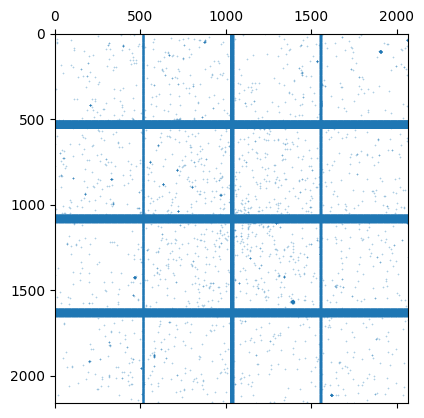

In [3]:
# How the data looks like
data = data_all[0]
plt.spy(data, markersize=0.1)

In [4]:
def array_to_sparse(array: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Convert an array to sparse representation"""
    array = np.ravel(array)
    indices = np.nonzero(array)[0]
    values = array[indices]
    return values, indices

In [5]:
# Sizes of the original and sparse representation
dsize = data.nbytes
print(f"Original size: {dsize / 1024**2:.2f} MB")

Original size: 17.06 MB


In [6]:
# Compression params for Blosc2
#blosc2.cparams_dflts["ntreads"] = 16
#blosc2.dparams_dflts["nthreads"] = 16
#ne.set_num_threads(8)
cpblosclz = dict(clevel=1, filters=[blosc2.Filter.SHUFFLE], codec=blosc2.Codec.BLOSCLZ, splitmode=blosc2.SplitMode.AUTO_SPLIT)
cplz4 = dict(clevel=1, filters=[blosc2.Filter.SHUFFLE], codec=blosc2.Codec.LZ4, splitmode=blosc2.SplitMode.AUTO_SPLIT)
cpzlib = dict(clevel=1, filters=[blosc2.Filter.SHUFFLE], codec=blosc2.Codec.ZLIB,
              splitmode=blosc2.SplitMode.ALWAYS_SPLIT)
cpzstd = dict(clevel=1, filters=[blosc2.Filter.SHUFFLE], codec=blosc2.Codec.ZSTD,
              splitmode=blosc2.SplitMode.NEVER_SPLIT)
#chunks = (2162, 2068)  # good speed wise - cratio is also good!
#blocks = (2162, 32)    # good speed wise - cratio is also good!
chunks = (2162 // 2, 2068 // 4)  # good speed wise - cratio is not that good
blocks = (2162 // 2, 32)    # good speed wise - cratio is not that good
#chunks = (2162 // 2, 2068)  # quite good for M1
#blocks = (2162 // 2, 32)    # quite good for M1
#chunks = (2162 // 8, 2068 // 2)  # good speed wise - cratio is not that good
#blocks = (32, 2068 // 2)  # good speed wise - cratio is not that good

all_cparams = {"BloscLZ": cpblosclz,
               "LZ4": cplz4,
               "ZLIB": cpzlib,
               "Zstd": cpzstd}

In [7]:
# Transform the numpy array to a blosc2 NDArray (which has special support for sparse arrays)
ctimes = {"BloscLZ": [],
          "LZ4": [],
          "ZLIB": [],
          "Zstd": []}
b2im_blosclz, b2im_lz4, b2im_zlib, b2im_zstd = [], [], [], []
for i in range(N):
    t0 = time()
    b2im_blosclz.append(blosc2.asarray(data, chunks=chunks, blocks=blocks, cparams=cpblosclz))
    ctimes["BloscLZ"].append(time() - t0)
    t0 = time()
    b2im_lz4.append(blosc2.asarray(data, chunks=chunks, blocks=blocks, cparams=cplz4))
    ctimes["LZ4"].append(time() - t0)
    t0 = time()
    b2im_zlib.append(blosc2.asarray(data, chunks=chunks, blocks=blocks, cparams=cplz4))
    ctimes["ZLIB"].append(time() - t0)
    t0 = time()
    b2im_zstd.append(blosc2.asarray(data, chunks=chunks, blocks=blocks, cparams=cpzstd))
    ctimes["Zstd"].append(time() - t0)

In [8]:
# Build a dict with different NDArrays
a = {
    "ZLIB": b2im_zlib,
    "BloscLZ": b2im_blosclz,
    "LZ4": b2im_lz4,
    "Zstd": b2im_zstd,
}
cratios = {
    "BloscLZ": [],
    "LZ4": [],
    "ZLIB": [],
    "Zstd": []}
for k, v in a.items():
    for i in range(N):
        cbytes = v[i].schunk.cbytes
        cratio = dsize / cbytes
        #print(f"{k} chunk {i} size: {cbytes / 1024:.2f} KB ({cratio:.1f}x)")
        cratios[k].append(cratio)

In [9]:
# Decompress (Blosc2)
dtimes = {
    "BloscLZ": [],
    "LZ4": [],
    "ZLIB": [],
    "Zstd": []}
for k, v in a.items():
    for i in range(N):
        t0 = time()
        #_ = v[i][:]
        nchunks = v[i].schunk.nchunks
        for j in range(nchunks):
            _ = v[i].schunk.decompress_chunk(j)
        dtimes[k].append(time() - t0)
        # t = time() - t0
        #print(f"{k} decompression: {t * 1000:.2f} ms ({dsize / t / 1024**2:.2f} MB/s)")


In [10]:
conv_times = {
    "BloscLZ": [],
    "LZ4": [],
    "ZLIB": [],
    "Zstd": []}
for i in range(N):
    t0 = time()
    _ = array_to_sparse(b2im_blosclz[i][:])
    conv_times["BloscLZ"].append(time() - t0)
    t0 = time()
    _ = array_to_sparse(b2im_lz4[i][:])
    conv_times["LZ4"].append(time() - t0)
    t0 = time()
    _ = array_to_sparse(b2im_zlib[i][:])
    conv_times["ZLIB"].append(time() - t0)
    t0 = time()
    _ = array_to_sparse(b2im_zstd[i][:])
    conv_times["Zstd"].append(time() - t0)

In [11]:
# Compute speeds for ctimes and dtimes
cspeeds, dspeeds = {}, {}
for k, v in ctimes.items():
    cspeeds[k] = [dsize / (x * 2**30) for x in v]
for k, v in dtimes.items():
    dspeeds[k] = [dsize / (x * 2**30) for x in v]

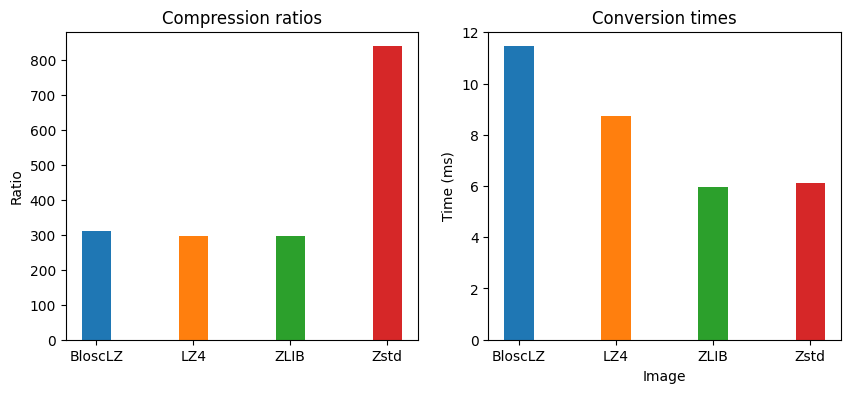

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
#plt.subplots_adjust(hspace=0.5, wspace=0.5)
for k, v in cratios.items():
    vmean = np.mean(v)
    ax[0].bar(k, vmean, label=k, width=.3)
    ax[0].set_title("Compression ratios")
    #ax[0].set_xlabel("Image")
    ax[0].set_axisbelow(False)
    ax[0].set_ylabel("Ratio")
    #ax[0].legend()
for k, v in conv_times.items():
    vms = np.array(v) * 1000
    #ax[1].plot(vms, label=k)
    vmean = np.mean(vms)
    ax[1].bar(k, vmean, label=k, width=.3)
    #ax[1].set_ylim(0, max(v) * 1.2)
    ax[1].set_title("Conversion times")
    ax[1].set_xlabel("Image")
    ax[1].set_ylabel("Time (ms)")
    #ax[1].legend()

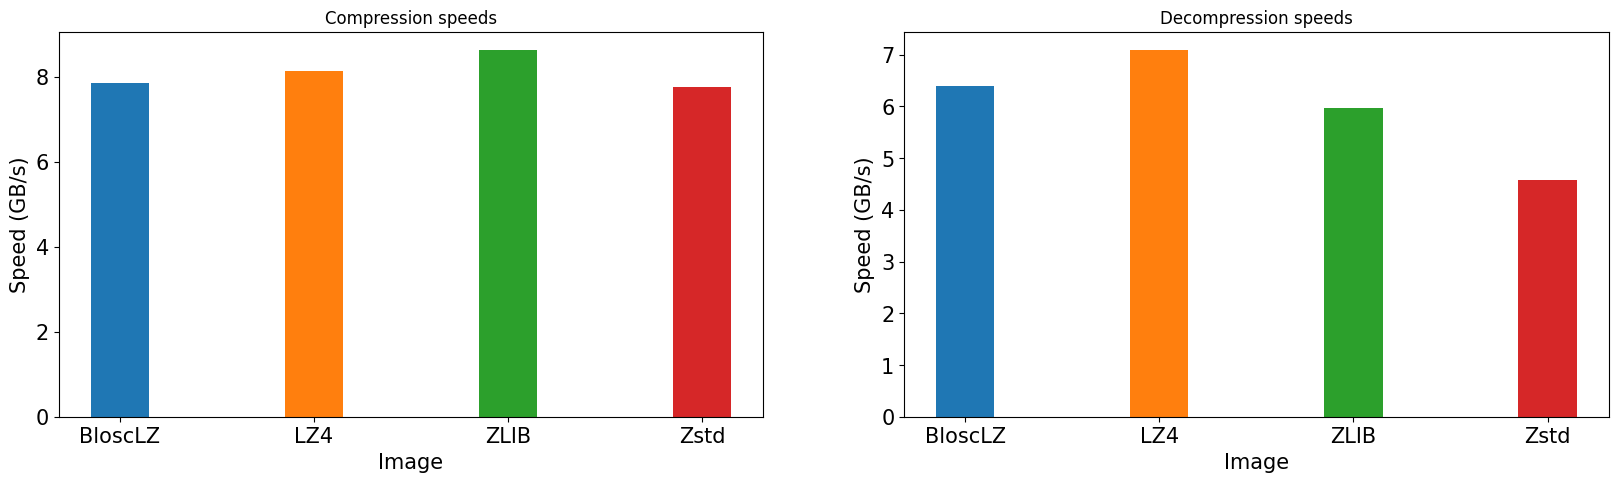

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
#plt.subplots_adjust(hspace=0.5, wspace=0.5)
# Increase the font size of all elements by 1.5 times
#plt.rcParams.update({'font.size': 15})
# Increase the font size of axes labels
for a_ in ax.flat:
    a_.tick_params(axis='both', which='major', labelsize=15)
    a_.xaxis.label.set_size(15)
    a_.yaxis.label.set_size(15)

for k, v in cspeeds.items():
    #ax[0].plot(v, label=k, linewidth=2.5)
    vmean = np.mean(v)
    ax[0].bar(k, vmean, label=k, width=.3)
    #ax[0].set_ylim(0, max(v) * 1.1)
    ax[0].set_title("Compression speeds")
    ax[0].set_xlabel("Image")
    ax[0].set_ylabel("Speed (GB/s)")
    #ax[0].legend(fontsize=15)
for k, v in dspeeds.items():
    #ax[1].plot(v, label=k, linewidth=2.5)
    vmean = np.mean(v)
    ax[1].bar(k, vmean, label=k, width=.3)
    #ax[1].set_ylim(0, max(v) * 1.1)
    ax[1].set_title("Decompression speeds")
    ax[1].set_xlabel("Image")
    ax[1].set_ylabel("Speed (GB/s)")
    #ax[1].legend(fontsize=15)

plt.savefig("sparse_image_stack_speeds.png")

In [14]:
times = {"BloscLZ": [], "LZ4": [], "ZLIB": [], "Zstd": []}
N2 = 10

In [15]:
# Compute the time to evaluate the sum of the compressed images
for k, v in a.items():
    data_sum = v[0]
    for i in range(1, N):
        data_sum += v[i]
    cparams = all_cparams[k]
    t0 = time()
    for j in range(N2):
        data_sum.evaluate(cparams=cparams)
    t = (time() - t0) / N2
    print(f"Time to evaluate the sum of the images (compr, {k}): {t * 1000:.2f} ms ({dsize / t / 1024**2:.2f} MB/s)")
    times[k].append(t)


Time to evaluate the sum of the images (compr, ZLIB): 8.74 ms (1951.56 MB/s)
Time to evaluate the sum of the images (compr, BloscLZ): 4.84 ms (3521.26 MB/s)
Time to evaluate the sum of the images (compr, LZ4): 4.66 ms (3660.04 MB/s)
Time to evaluate the sum of the images (compr, Zstd): 6.41 ms (2659.45 MB/s)


In [16]:
# Compute the time to evaluate the sum of the uncompressed images (numpy
t0 = time()
for j in range(N2):
    npsum = data_all[0]
    for i in range(1, N):
        npsum += data_all[i]
t = (time() - t0) / N2
print(f"Time to evaluate the sum of the images (uncompr, numpy): {t * 1000:.2f} ms ({dsize / t / 1024**2:.2f} MB/s)")
times["numpy"] = t

Time to evaluate the sum of the images (uncompr, numpy): 4.04 ms (4216.85 MB/s)


In [17]:
# Compute the time to evaluate the sum of the uncompressed images (numexpr)
operands = {f"o{i}": data_all[i] for i in range(N)}
t0 = time()
for j in range(N2):
    nesum = ne.evaluate(data_sum.expression, global_dict=operands)
t = (time() - t0) / N2
print(f"Time to evaluate the sum of the images (uncompr, numexpr): {t * 1000:.2f} ms ({dsize / t / 1024**2:.2f} MB/s)")
times["numexpr"] = t


Time to evaluate the sum of the images (uncompr, numexpr): 3.66 ms (4653.79 MB/s)


In [18]:
# Convert to different scipy sparse formats
sparse_arrays = {}
#sparse_arrays["LIL"] = [scipy.sparse.lil_array(data) for data in data_all]
#sparse_arrays["DOK"] = [scipy.sparse.dok_matrix(data) for data in data_all]
sparse_arrays["COO"] = [scipy.sparse.coo_matrix(data) for data in data_all]
sparse_arrays["CSR"] = [scipy.sparse.csr_matrix(data) for data in data_all]
sparse_arrays["CSC"] = [scipy.sparse.csc_matrix(data) for data in data_all]
sparse_arrays["BSR"] = [scipy.sparse.bsr_matrix(data) for data in data_all]

In [19]:
# Sizes of the sparse arrays (bitshuffle+lz4+zstd)
h5f = h5py.File("sparse_images_shuffle_dc_test.h5", "r")
bslz4_dataset = h5f["bslz4"]
bszstd_dataset = h5f["bszstd"]
cratios["bslz4"] = dsize / len(bslz4_dataset.id.read_direct_chunk((0, 0, 0))[1])
cratios["bszstd"] = dsize / len(bszstd_dataset.id.read_direct_chunk((0, 0, 0))[1])

In [20]:
# Sizes of the sparse arrays (canonical representation)
_dsize = sum([x.data.nbytes for x in data_all])
for k, v in sparse_arrays.items():
    dsize_ = 0
    if k == "COO":
        dsize_ += sum([x.data.nbytes + x.row.nbytes + x.col.nbytes for x in v])
    else:
        dsize_ = sum([x.data.nbytes + x.indices.nbytes + x.indptr.nbytes for x in v])
    print(f"Size of the sparse array ({k}): {dsize_ / 1024**2:.2f} MB")
    print(f"cratio of sparse arrays ({k}): {_dsize / dsize_:.2f}x")
    cratios[k] = _dsize / dsize_

Size of the sparse array (COO): 15.58 MB
cratio of sparse arrays (COO): 5.47x
Size of the sparse array (CSR): 10.43 MB
cratio of sparse arrays (CSR): 8.18x
Size of the sparse array (CSC): 10.43 MB
cratio of sparse arrays (CSC): 8.18x
Size of the sparse array (BSR): 6.94 MB
cratio of sparse arrays (BSR): 12.29x


In [21]:
# Compute the time to evaluate the sum of the images in sparse format (LIL)
for k, v in sparse_arrays.items():
    t0 = time()
    for j in range(N2):
        data_sum = v[0]
        for i in range(1, N):
            data_sum += v[i]
    t = (time() - t0) / N2
    print(f"Time to evaluate the sum of the images (sparse, {k}): {t * 1000:.2f} ms ({dsize / t / 1024**2:.2f} MB/s)")
    times[k] = t

Time to evaluate the sum of the images (sparse, COO): 4.91 ms (3474.88 MB/s)
Time to evaluate the sum of the images (sparse, CSR): 1.38 ms (12346.40 MB/s)
Time to evaluate the sum of the images (sparse, CSC): 1.39 ms (12256.70 MB/s)
Time to evaluate the sum of the images (sparse, BSR): 1.98 ms (8634.53 MB/s)


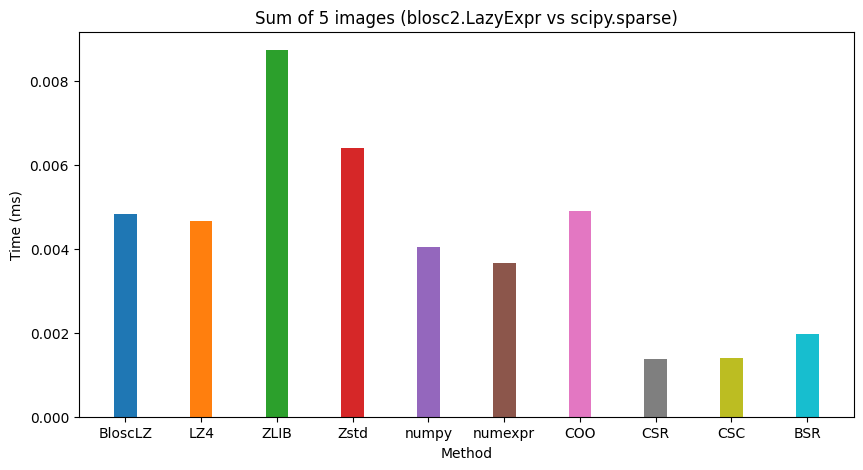

In [22]:
# Plot the times
#del times['BloscLZ']
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
#plt.subplots_adjust(hspace=0.5, wspace=0.5)
for k, v in times.items():
    vmean = np.mean(v)
    ax.bar(k, vmean, label=k, width=.3)
    ax.set_title(f"Sum of {N} images (blosc2.LazyExpr vs scipy.sparse)")
    ax.set_xlabel("Method")
    ax.set_ylabel("Time (ms)")

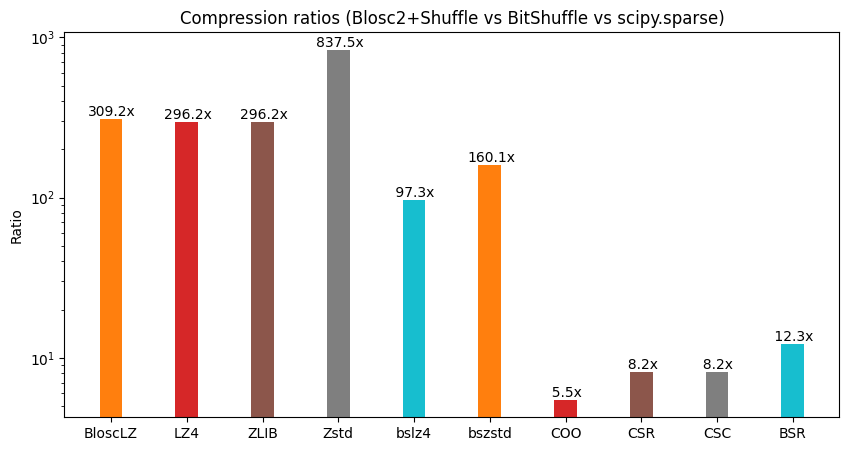

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for k, v in cratios.items():
    vmean = np.mean(v)
    ax.bar(k, vmean, label=k, width=.3, log=True)
    ax.set_title("Compression ratios (Blosc2+Shuffle vs BitShuffle vs scipy.sparse)")
    #ax.set_xlabel("Image")
    ax.set_axisbelow(False)
    ax.set_ylabel("Ratio")
    #ax.legend()
    bars = ax.bar(k, vmean, label=k, width=.3, log=True)
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() - bar.get_width()/2.0, yval, f"{vmean:5.1f}x", va='bottom')
plt.savefig("sparse_image_stack_ratios.png")